In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics

## Part 1: Introduction

The oil and gas industry began testing hydraulic fracturing as a technology since late 1940s (<a href = "http://www.kgs.ku.edu/PRS/Fracturing/Frac_Paper_SPE_152596.pdf">ref</a>). In 1997, Mitchell Energy applied the technology to the Barnett Shale, resulting in greater 90-day production than any previous wells completed by the company (<a href = "https://en.wikipedia.org/wiki/Hydraulic_fracturing#Shales">ref</a>). The development of hydraulic fracturing and horizontal drilling led to the "Shale Boom," and for the first time since the oil export ban in 1973 (following the OPEC oil embargo), the US exported oil (<a href="https://www.forbes.com/sites/rrapier/2017/09/30/why-the-u-s-exports-oil/#58ccc7793b07">ref</a>). Since 2006, the US has been importing less and less crude oil and petroleum products (<a href="https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=WTTNTUS2&f=W">ref</a>). With the growing shale development and the addition of home-grown renewable energy sources, the US is well on its way to energy independence.

Hydraulic fracturing is ubiquitous in 21st century oil and gas development. Nearly all of the new wells in the US are horizontal, hydraulically fractured wells. These days, horizontal wells can extend over 15,000' long (laterally) and contain more than 40 stages. A stage describes a short section of the lateral portion of the wellbore to be frac'ed. For more information on how fracing works, see this <a href="https://youtu.be/VY34PQUiwOQ?t=2m46s">YouTube video</a>.

In a hydraulic fracturing (or "frac") job, each stage will generate a "pump curve." A pump curve describes the concentration of sand pumped over time (or as a proxy for time, cumulative volume pumped; the more time passes, the greater the cumulative volume). 

Below is a sample a pump curve for a single well looks like.

Text(0,0.5,'Concentration')

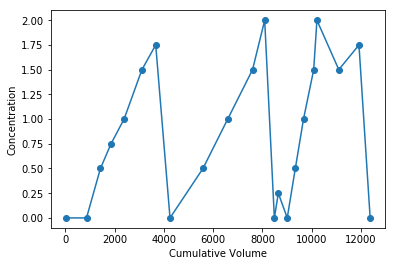

In [2]:
# Sample Data
x = [15.8,857.2,1422.3,1852.7,2383.1,3108.1,3667.9,4248.6,5585.9,6592.1,7600.7,8093.4,8486.7,8647.1,9009.1,9337.1,9670.1,10084.1,10215.2,11104.2,11922.2,12377]
y = [0,0,0.5,0.75,1,1.5,1.75,0,0.5,1,1.5,2,0,0.25,0,0.5,1,1.5,2,1.5,1.75,0]
plt.plot(x,y,'o-')
plt.xlabel('Cumulative Volume')
plt.ylabel('Concentration')

As you can see, there is a pattern of "ramps" (when concentration increases).

**Objective:** I would like to capture the pattern of these ramps and run a clustering algorithm them to find "pump curve families."

*Secondary Objective:* I will use the pump curve famililies, in addition to some other features in a regression tree or other classification model to determine which pump curve family results in high 180-day cumulative oil production.

In [3]:
# Function to determine whether the pump schedule is ramping up
# Count the number of ramps
# Writing the code to see if I can determine the "ramp status" of the pump curve to be used later

def tot_ramp(conc): # Where conc is an list
    concl = list(y)
    ramping = 0
    ramp_count = 0

    for i, num in enumerate(concl): # Loop through data
        if i == len(concl)-1: # Out of bounds condition
            break
        if num > concl[i-1] and num >= concl[i+1]: # End ramp condition
            ramping += 1
            if ramping == 1: ramp_count +=1 # Count ramp
            ramping = 0
        elif num < concl[i+1]: # Ramping condition
            ramping += 1
            if ramping == 1: ramp_count +=1 # Count ramp
    return ramp_count

# Test function on  sample data from above
tot_ramp(y)

5

## Part 2: Exploratory Data Analysis

- What does the distribution look like for max cum fluid?

In [6]:
# Read in data
pump = pd.read_table('./pump_schedule_designs_clean.csv', sep=',')
pump.head()

,WELL_ID,VOL,CONC,RATE,SAND,CUM_FLUID,Interpreter
0,1000,1000.00,0.0,15,L,0.000000,kjw
1,1000,500.00,0.0,15,L,23.809524,kjw
2,1000,4000.00,0.0,15,L,35.714286,kjw
3,1000,20000.00,0.0,100,L,130.952381,kjw
4,1000,8000.00,0.5,100,A,607.142857,kjw


This data table contains the pump schedule for multiple wells. Each well is designated by its `WELL_ID`. The columns of interest are `CUM_FLUID` and `CON`.

In [7]:
# Determine data types
pump.dtypes

# Change WELL_ID from integer to string
pump['WELL_ID'] = pump['WELL_ID'].astype(str)
pump.dtypes

WELL_ID         object
VOL             object
CONC           float64
RATE             int64
SAND            object
CUM_FLUID      float64
Interpreter     object
dtype: object

In [9]:
# Data Summary grouped by wells.
# Gives describe() info
pump[pump['WELL_ID'] == '1000'].describe()

,CONC,RATE,CUM_FLUID
count,28.000000,28.000000,28.000000
mean,0.848214,87.321429,3135.638605
std,0.749504,31.724571,2274.102484
min,0.000000,0.000000,0.000000
25%,0.187500,100.000000,1202.380953
50%,0.625000,100.000000,2773.809524
75%,1.500000,100.000000,5166.666667
max,2.500000,100.000000,6964.547619


In [10]:
# Check the data table
pump.describe()

,CONC,RATE,CUM_FLUID
count,14919.000000,14954.000000,14954.000000
mean,0.968220,77.013909,4572.319364
std,1.927138,30.192225,3404.219541
min,0.000000,0.000000,0.000000
25%,0.000000,75.000000,1698.750000
50%,0.750000,90.000000,4276.500000
75%,1.500000,100.000000,6976.190476
max,202.000000,105.000000,17826.484530


Notice that there is some missing data in the `CONC` column.

In [11]:
# Replace all NaN values in CONC column with zeroes.
pump['CONC'].replace(np.nan, 0, inplace=True)

In [12]:
# How many wells are in the data set?
pump['WELL_ID'].nunique()

708

In [13]:
# Double-check
len(pump['WELL_ID'].value_counts())

708

In [14]:
# Store it
num_wells = pump['WELL_ID'].nunique()

In [15]:
# Get array of wells
wells = pump['WELL_ID'].unique()
wells[0]

'1000'

In [16]:
# Get the max cum volume for each well
pump_maxcum = pd.DataFrame(pump.groupby('WELL_ID')[['WELL_ID','CUM_FLUID']].max())

# Change the column name
pump_maxcum.rename(index=str, columns={'CUM_FLUID':'MAX_FLUID'}, inplace=True)
# pump_maxcum.head(10)

# Join values of pump_maxcum to pump
pump_final = pd.merge(pump, pump_maxcum, on='WELL_ID', how='left')

# Calculate fraction of job by CUM_FLUID_BBL pumped. Normalize data.
pump_final['JOB_FRAC'] = pump_final['CUM_FLUID'] / pump_final['MAX_FLUID']

# Convert CUM_FLUID to different unit
pump_final['CUM_FLUID_UNIT'] = pump_final['CUM_FLUID']*42/10000

pump_final.head(10)

,WELL_ID,VOL,CONC,RATE,SAND,CUM_FLUID,Interpreter,MAX_FLUID,JOB_FRAC,CUM_FLUID_UNIT
0,1000,1000.00,0.00,15,L,0.000000,kjw,6964.547619,0.000000,0.00
1,1000,500.00,0.00,15,L,23.809524,kjw,6964.547619,0.003419,0.10
2,1000,4000.00,0.00,15,L,35.714286,kjw,6964.547619,0.005128,0.15
3,1000,20000.00,0.00,100,L,130.952381,kjw,6964.547619,0.018803,0.55
4,1000,8000.00,0.50,100,A,607.142857,kjw,6964.547619,0.087176,2.55
5,1000,8000.00,0.75,100,A,797.619048,kjw,6964.547619,0.114526,3.35
6,1000,12000.00,1.00,100,A,988.095238,kjw,6964.547619,0.141875,4.15
7,1000,12000.00,1.50,100,A,1273.809524,kjw,6964.547619,0.182899,5.35
8,1000,10000.00,2.00,100,A,1559.523810,kjw,6964.547619,0.223923,6.55
9,1000,8000.00,2.50,100,A,1797.619048,kjw,6964.547619,0.258110,7.55


Remember, I am interested in characterizing the ramp by slope and initiation point. In order to do that, I have to determine whether or not the pump curve is ramping (when concentration increases from the previous step).

In [17]:
# Determine the total number of ramps for each well

# Initiate empty data frame to store data
ramps = pd.DataFrame(columns = ['WELL_ID','TOT_RAMPS'])

# Loop through wells and extract concentration curve for each well
for i in range(0,num_wells):
    y = pump_final[pump_final['WELL_ID']==wells[i]].CONC
    # Return ramp count using tot_ramp() function
    ramps = ramps.append({'WELL_ID': wells[i], 'TOT_RAMPS': tot_ramp(y)}, ignore_index=True)

In [18]:
# Store frequency count for each uniqe number of ramps into data frame
count_ramps = pd.DataFrame(ramps['TOT_RAMPS'].value_counts())

# Rename the column
count_ramps.rename(index=int, columns={'TOT_RAMPS':'WELL_COUNT'}, inplace=True)

# Store index into an array called "values"
values = np.sort(np.array(count_ramps.index))

# Display data frame sorted on index values
count_ramps.sort_index(axis=0)

# What is the most prevalent value of ramps? (Ans: 2)

,WELL_COUNT
0,5
1,49
2,295
3,146
4,63
5,38
6,36
7,20
8,25
9,7


Text(0.5,1,'Wells with Specified Number of Ramps')

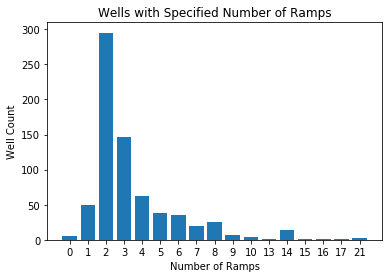

In [19]:
# Attempted to plot histogram. Using np.hist was taking too long...not sure why
frequency = count_ramps['WELL_COUNT'].sort_index(axis=0)
y_pos = np.arange(len(frequency))

plt.bar(y_pos, list(frequency))
plt.xticks(y_pos, values)
plt.xlabel('Number of Ramps')
plt.ylabel('Well Count')
plt.title('Wells with Specified Number of Ramps')

In [20]:
# Distribution of max cum fluid
pump_final

,WELL_ID,VOL,CONC,RATE,SAND,CUM_FLUID,Interpreter,MAX_FLUID,JOB_FRAC,CUM_FLUID_UNIT
0,1000,1000.00,0.00,15,L,0.000000,kjw,6964.547619,0.000000,0.0000
1,1000,500.00,0.00,15,L,23.809524,kjw,6964.547619,0.003419,0.1000
2,1000,4000.00,0.00,15,L,35.714286,kjw,6964.547619,0.005128,0.1500
3,1000,20000.00,0.00,100,L,130.952381,kjw,6964.547619,0.018803,0.5500
4,1000,8000.00,0.50,100,A,607.142857,kjw,6964.547619,0.087176,2.5500
5,1000,8000.00,0.75,100,A,797.619048,kjw,6964.547619,0.114526,3.3500
6,1000,12000.00,1.00,100,A,988.095238,kjw,6964.547619,0.141875,4.1500
7,1000,12000.00,1.50,100,A,1273.809524,kjw,6964.547619,0.182899,5.3500
8,1000,10000.00,2.00,100,A,1559.523810,kjw,6964.547619,0.223923,6.5500
9,1000,8000.00,2.50,100,A,1797.619048,kjw,6964.547619,0.258110,7.5500


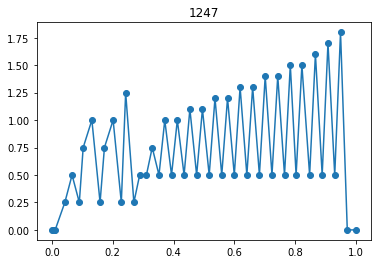

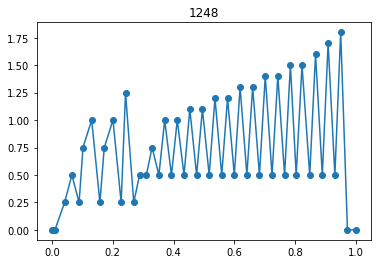

In [21]:
# What do the pump curves with higher (>= 9) ramps look like?
# hi_ramps = ramps[ramps['TOT_RAMPS'] >= 9].index.values
hi_ramps = ramps[ramps['TOT_RAMPS'] == 21].index.values

for i in hi_ramps:
    x = pump_final[pump_final['WELL_ID']==wells[i]].JOB_FRAC
    y = pump_final[pump_final['WELL_ID']==wells[i]].CONC
    plt.figure()
    plt.plot(x,y,'o-')
    plt.title(wells[i])

In [22]:
hi_ramps[0]

247

## Part 3: Data Analysis

The total number of ramps is:  7


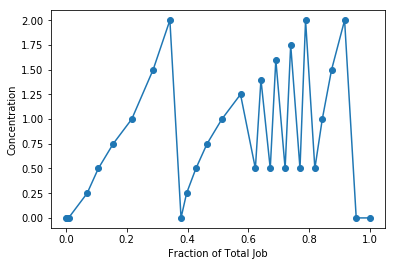

In [23]:
# Get concentration for a single well and plot
# (test to see if I can do it for one well before looping through entire data set)
# wString = input('Enter a number within the range 0 and 663 inclusive.')
# w = int(wString) # index for wells array. Can be any value from 0-663
w = 5 #, 24, 147, 250, 251, 252
x = pump_final[pump_final['WELL_ID']==wells[w]].JOB_FRAC
y = pump_final[pump_final['WELL_ID']==wells[w]].CONC
plt.plot(x,y,'o-')
plt.xlabel('Fraction of Total Job')
plt.ylabel('Concentration')

# Return ramp count using tot_ramp() function written above
print("The total number of ramps is: ",tot_ramp(y))

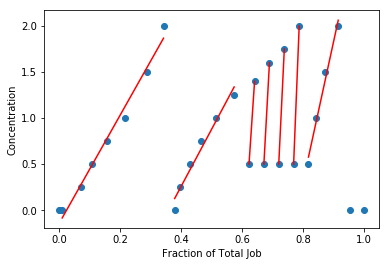

In [24]:
# Objective: Store x- and y-values for each ramp in a list of lists.
# Primary list is as long as the number of ramps
# Secondary list is of the concentration values within the ramp

fraction = list(x)
conc = list(y)
fractions = [[] for x in range(0,tot_ramp(y))] # initiate blank list of lists
concs = [[] for x in range(0,tot_ramp(y))] # initiate blank list of lists
ramping = 0 # Counts the number of steps while ramping
ramp_count = 0 # Counts the number of ramps


for i, num in enumerate(conc): # Loop through data
    if i == len(conc)-1: # Out of bounds condition
        break
    if num > conc[i-1] and num >= conc[i+1]: # End ramp condition
        ramping += 1
        status = 2
        if ramping == 1: ramp_count +=1 # Count ramp
        concs[ramp_count-1].append(num) # Append concentration to list
        fractions[ramp_count-1].append(fraction[i]) # Append fraction to list
        # Reset ramp status
        status = 0
        ramping = 0
    elif num < conc[i+1]: # Ramping condition
        ramping += 1
        status = 1
        if ramping == 1: ramp_count +=1 # Count ramp
        concs[ramp_count-1].append(num) # Append concentration to list
        fractions[ramp_count-1].append(fraction[i]) # Append fraction to list
    else:
        ramping = 0
        status = 0
        
# Test to make sure that all arrays for concs (y-values) and fractions (x-values) are equal
test = tot_ramp(y)

for i in range(0,test):
    if len(concs[i]) == len(fractions[i]):
        continue
    else:
        print("Array {} is NOT the same length".format(i))
        break
        
# Remove ramps with less than X steps
# threshold = 3
# for i, item in enumerate(ramps):
#     if len(concs[i]) < threshold:
#         concs.pop(i)
#         fractions.pop(i)

# What does fractions (x-value) look like now?
# print(fractions)

# What does concs (y-value) lok like now?
# print(concs)

# Fit each line in a loop through the list of lists
from sklearn.linear_model import LinearRegression

# Instantiate linear regression model
lr = LinearRegression()

# Plot the pump curve of interest
plt.plot(x,y,'o')
plt.xlabel('Fraction of Total Job')
plt.ylabel('Concentration')

# Loop through each ramp
for i in range(0,test):
    X_test = np.array(fractions[i])
    X_test  = X_test.reshape(-1,1)
    y_test = np.array(concs[i])

    lr.fit(X_test, y_test)
    y_pred = lr.predict(X_test)
    # print(lr.intercept_)
    # print(lr.coef_)
    plt.plot(X_test, y_pred, '-r')

After playing around and looking at the wells with lots of ramps, I think as a first pass I will decide to keep them in the data set (not define the number of steps needed to quality as a "true ramp.")

**NOTE:** After discussing with my colleagues, I believe the best approach is to not normalize the x-axis to "Fraction of Total Job." Instead, I will use the `CUM_FLUID_UNIT` as the x-axis to capture the true slope of the ramp.

**The Plan:**
- Figure out how to extract INTERCEPTS and RAMP_STARTS.
- Figure out how to store the slope and initiation point

**The Challenge:**
Pump schedules vary (as we see above) in the number of ramps they have. How do we deal with that?

In [25]:
# What happens when you make a Data Frame from lists of unequal length?
l = [[3,4,5],[5,6,7,8,9,10],[2,3,4]]
df = pd.DataFrame(l)
df
# A: Pandas will fill in the missing columns with NaNs. AWESOME!

,0,1,2,3,4,5
0,3,4,5,NaN,NaN,NaN
1,5,6,7,8.0,9.0,10.0
2,2,3,4,NaN,NaN,NaN


In [26]:
# Initiate a list of lists to store slope and initation point
data = []

# Instantiate linear regression model
lr = LinearRegression()

In [27]:
#### BEGIN LOOP ####
# w =  401 # Iterator
w_max = len(wells)

for w in range(0,w_max):
    # Extract pump curve for well i
    x = pump_final[pump_final['WELL_ID']==wells[w]].CUM_FLUID_UNIT
    y = pump_final[pump_final['WELL_ID']==wells[w]].CONC

    # Store x- and y-values for each ramp in a list of lists (fractions and concs)
    fraction = list(x)
    conc = list(y)
    fractions = [[] for x in range(0,tot_ramp(y))] # initiate blank list of lists
    concs = [[] for x in range(0,tot_ramp(y))] # initiate blank list of lists

    ramping = 0 # Counts the number of steps while ramping
    ramp_count = 0 # Counts the number of ramps


    for i, num in enumerate(conc): # Loop through data
        if i == len(conc)-1: # Out of bounds condition
            break
        if num > conc[i-1] and num >= conc[i+1]: # End ramp condition
            ramping += 1
            status = 2
            if ramping == 1: ramp_count +=1 # Count ramp
            concs[ramp_count-1].append(num) # Append concentration to list
            fractions[ramp_count-1].append(fraction[i]) # Append fraction to list
            # Reset ramp status
            status = 0
            ramping = 0
        elif num < conc[i+1]: # Ramping condition
            ramping += 1
            status = 1
            if ramping == 1: ramp_count +=1 # Count ramp
            concs[ramp_count-1].append(num) # Append concentration to list
            fractions[ramp_count-1].append(fraction[i]) # Append fraction to list
        else:
            ramping = 0
            status = 0

    # Fit a line to each ramp
    data_sub = [] # List containing slope and initiation point for each ramp

    for i in range(0,ramp_count): # Loop through each ramp
        X_test = np.array(fractions[i]).reshape(-1,1)
        y_test = np.array(concs[i])

        data_sub.append(fractions[i][0])

        lr.fit(X_test, y_test)
        data_sub.append(lr.coef_[0])

    data.append(data_sub)
    print('Well {} of {} completed.'.format(w+1, w_max))
### END LOOP ###

Well 1 of 708 completed.
Well 2 of 708 completed.
Well 3 of 708 completed.
Well 4 of 708 completed.
Well 5 of 708 completed.
Well 6 of 708 completed.
Well 7 of 708 completed.
Well 8 of 708 completed.
Well 9 of 708 completed.
Well 10 of 708 completed.
Well 11 of 708 completed.
Well 12 of 708 completed.
Well 13 of 708 completed.
Well 14 of 708 completed.
Well 15 of 708 completed.
Well 16 of 708 completed.
Well 17 of 708 completed.
Well 18 of 708 completed.
Well 19 of 708 completed.
Well 20 of 708 completed.
Well 21 of 708 completed.
Well 22 of 708 completed.
Well 23 of 708 completed.
Well 24 of 708 completed.
Well 25 of 708 completed.
Well 26 of 708 completed.
Well 27 of 708 completed.
Well 28 of 708 completed.
Well 29 of 708 completed.
Well 30 of 708 completed.
Well 31 of 708 completed.
Well 32 of 708 completed.
Well 33 of 708 completed.
Well 34 of 708 completed.
Well 35 of 708 completed.
Well 36 of 708 completed.
Well 37 of 708 completed.
Well 38 of 708 completed.
Well 39 of 708 comple

Well 323 of 708 completed.
Well 324 of 708 completed.
Well 325 of 708 completed.
Well 326 of 708 completed.
Well 327 of 708 completed.
Well 328 of 708 completed.
Well 329 of 708 completed.
Well 330 of 708 completed.
Well 331 of 708 completed.
Well 332 of 708 completed.
Well 333 of 708 completed.
Well 334 of 708 completed.
Well 335 of 708 completed.
Well 336 of 708 completed.
Well 337 of 708 completed.
Well 338 of 708 completed.
Well 339 of 708 completed.
Well 340 of 708 completed.
Well 341 of 708 completed.
Well 342 of 708 completed.
Well 343 of 708 completed.
Well 344 of 708 completed.
Well 345 of 708 completed.
Well 346 of 708 completed.
Well 347 of 708 completed.
Well 348 of 708 completed.
Well 349 of 708 completed.
Well 350 of 708 completed.
Well 351 of 708 completed.
Well 352 of 708 completed.
Well 353 of 708 completed.
Well 354 of 708 completed.
Well 355 of 708 completed.
Well 356 of 708 completed.
Well 357 of 708 completed.
Well 358 of 708 completed.
Well 359 of 708 completed.
W

Well 638 of 708 completed.
Well 639 of 708 completed.
Well 640 of 708 completed.
Well 641 of 708 completed.
Well 642 of 708 completed.
Well 643 of 708 completed.
Well 644 of 708 completed.
Well 645 of 708 completed.
Well 646 of 708 completed.
Well 647 of 708 completed.
Well 648 of 708 completed.
Well 649 of 708 completed.
Well 650 of 708 completed.
Well 651 of 708 completed.
Well 652 of 708 completed.
Well 653 of 708 completed.
Well 654 of 708 completed.
Well 655 of 708 completed.
Well 656 of 708 completed.
Well 657 of 708 completed.
Well 658 of 708 completed.
Well 659 of 708 completed.
Well 660 of 708 completed.
Well 661 of 708 completed.
Well 662 of 708 completed.
Well 663 of 708 completed.
Well 664 of 708 completed.
Well 665 of 708 completed.
Well 666 of 708 completed.
Well 667 of 708 completed.
Well 668 of 708 completed.
Well 669 of 708 completed.
Well 670 of 708 completed.
Well 671 of 708 completed.
Well 672 of 708 completed.
Well 673 of 708 completed.
Well 674 of 708 completed.
W

In [28]:
# Create data frame from slope and initatiation point data
data_df = pd.DataFrame(data)

In [29]:
# Replace all NaN values with zeroes
data_df.replace(np.nan, 0, inplace=True)

In [30]:
# Define column names
col_names = []
count = 1
for i in range(len(data_df.columns)):
    if (i+1) % 2 == 0: # Even (Slopes)
        col_names.append('m'+ str(count))
        count +=1
    else: # Odd (Initiation Points)
        col_names.append('i'+ str(count))

In [31]:
data_df.columns = col_names

In [32]:
# data_df['wells'] = wells

In [33]:
data_df

,i1,m1,i2,m2,i3,m3,i4,m4,i5,m5,...,i17,m17,i18,m18,i19,m19,i20,m20,i21,m21
0,0.5500,0.360048,8.3500,0.193467,16.5500,1.666667,19.15,2.083333,21.55,2.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2000,0.110414,12.0000,0.165236,0.0000,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2000,0.222222,7.4000,0.224359,0.0000,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.2000,0.222222,7.4000,0.224359,0.0000,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.2000,0.222222,7.4000,0.224359,0.0000,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.3000,0.178967,12.4000,0.189154,20.4000,1.500000,22.00,1.833333,23.60,2.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.2000,0.176609,8.5000,0.165236,0.0000,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.3000,0.178967,12.4000,0.189154,20.4000,1.500000,22.00,1.833333,23.60,2.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.2000,0.150000,10.2000,0.207089,0.0000,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.2000,0.150000,10.2000,0.207089,0.0000,0.000000,0.00,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-Means Clustering

In [34]:
# Scale the data
data_df_sc = preprocessing.MinMaxScaler().fit_transform(data_df)

In [35]:
# Use k-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(data_df_sc)

# Calculate metrics
labels = kmeans.labels_
labels_arr = pd.Series(kmeans.labels_)
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_
silhouette = metrics.silhouette_score(data_df_sc, labels, metric='euclidean')

In [36]:
silhouette

0.5134611167824622

In [37]:
inertia

76.11929397937422

That's not a bad silhouette score! Let's see if there's an optimum

In [38]:
inertias = []
silhouettes = []

for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data_df_sc)
    labels = kmeans.labels_
    inertias.append(kmeans.inertia_)
    silhouettes.append(metrics.silhouette_score(data_df_sc, labels, metric='euclidean'))

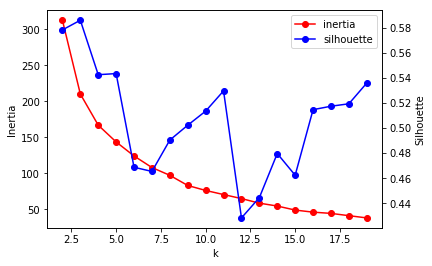

In [39]:
# Plot the inertias and silouettes
fig, iner = plt.subplots()
ax1 = iner.plot(range(2,20),inertias,'ro-', label='inertia')
iner.set_xlabel('k')
iner.set_ylabel('Inertia')

sil = iner.twinx()
ax2 = sil.plot(range(2,20),silhouettes,'bo-', label='silhouette')
sil.set_ylabel('Silhouette')
iner.legend()

lns = ax1+ax2
labs = ['inertia','silhouette']
iner.legend(lns, labs, loc=0)

plt.show()

# We want a high silhouette (close to 1, clusters are far apart)
# We want a low inertia (clusters are dense)

Looks like the best silhouette score is at 2 clusters, but we're not losing too much in the silhouette score but gaining a lot in the inertia if we increase `k`. The silhouette score begins to increase after k = 7. At k = 11 it hits a local maximum.

In [40]:
# Run kmeans with optimum parameters
# Use k-means clustering
kmeans = KMeans(n_clusters=11, random_state=0).fit(data_df_sc)

# Calculate metrics
labels = kmeans.labels_
labels_arr = pd.Series(kmeans.labels_)
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_
silhouette = metrics.silhouette_score(data_df_sc, labels, metric='euclidean')

In [41]:
inertia

70.43312702662966

In [42]:
silhouette

0.5295709337994079

In [56]:
# Create a dataframe with wells and labels
category_df = pd.DataFrame(labels)
category_df['WELL_ID'] = wells

# Export labels to csv
pd.DataFrame.to_csv(category_df,'pump_schedule_cat.csv', index=False)

In [57]:
pump_category = pd.merge(pump_final, category_df, on='WELL_ID', how='left')
pump_category.rename(index=int, columns={0:'CATEGORY'}, inplace=True)

In [47]:
cat = 3

# Get well list in category as series
well_series = pump_category[pump_category['CATEGORY']==cat]['WELL_ID'].value_counts()

# Convert series into list
well_list = list(well_series.index.values) 
len(well_list)

26

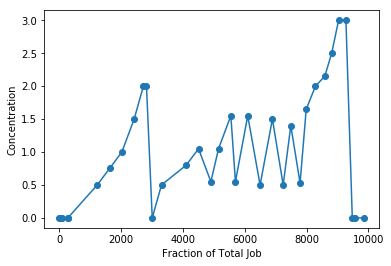

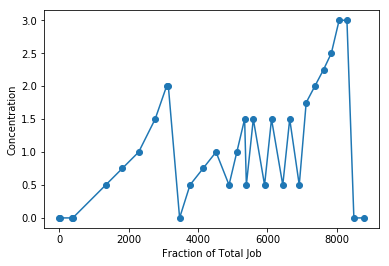

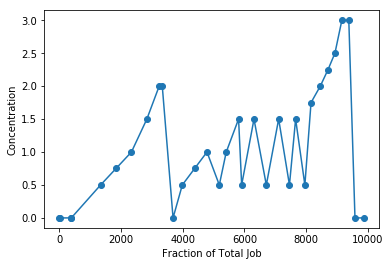

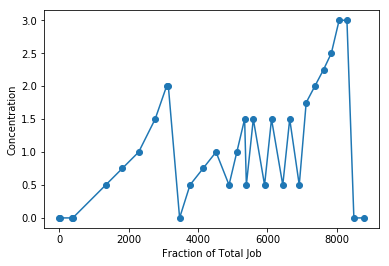

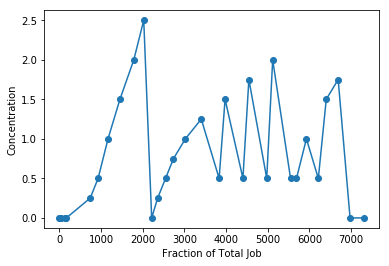

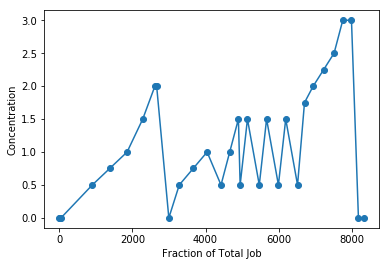

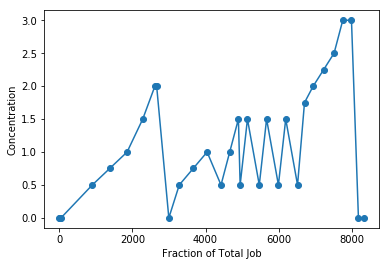

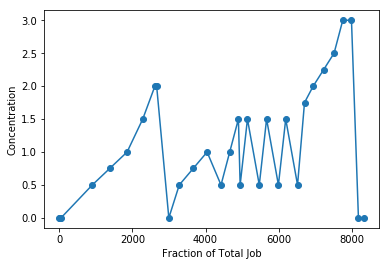

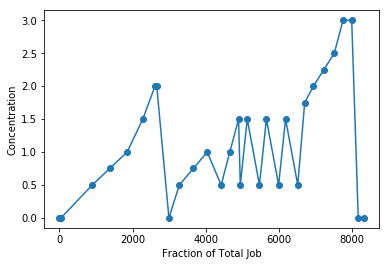

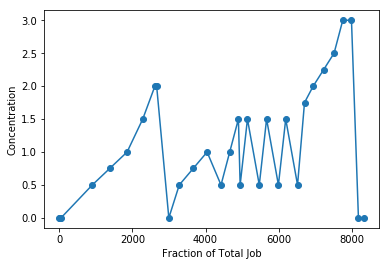

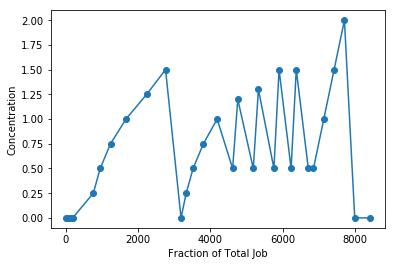

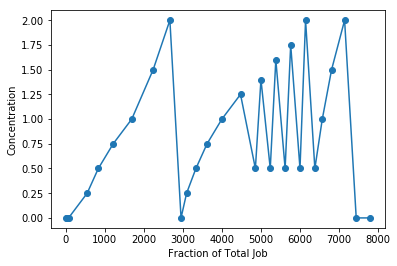

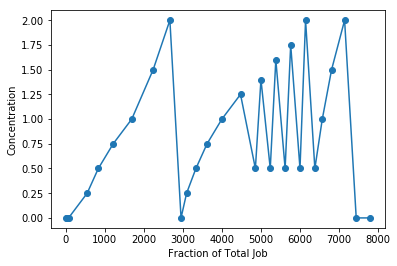

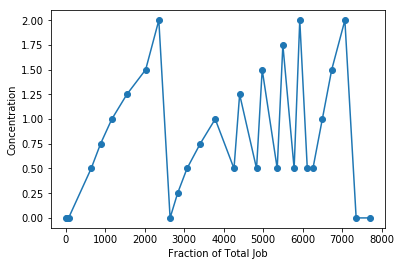

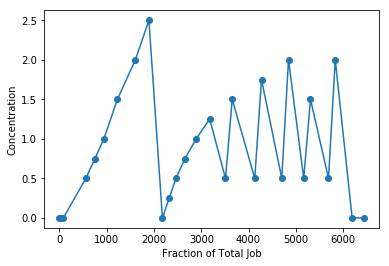

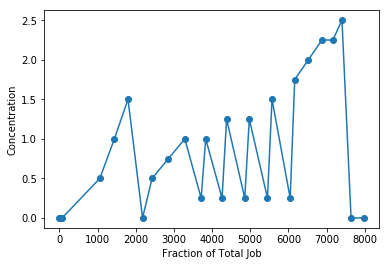

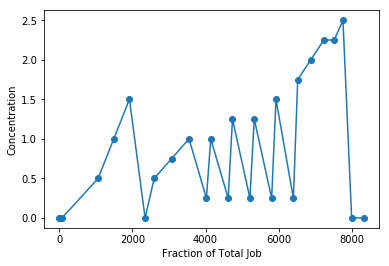

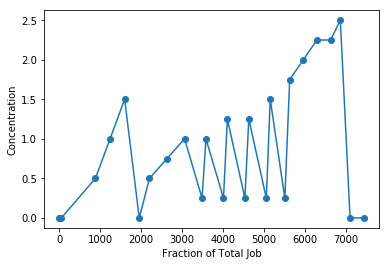

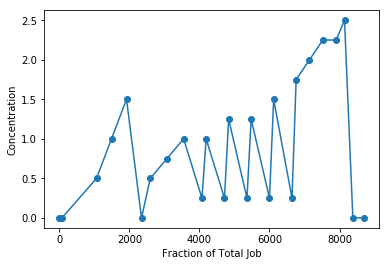

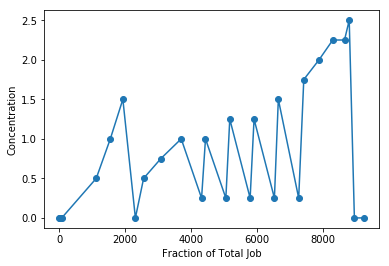

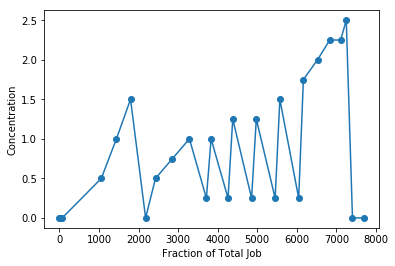

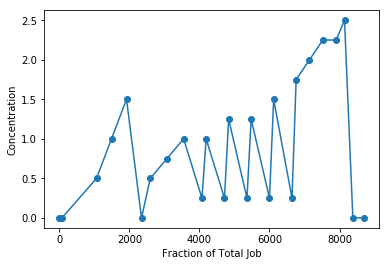

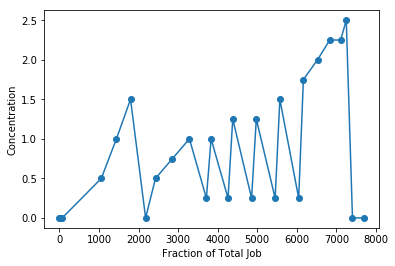

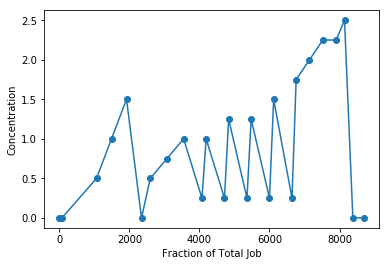

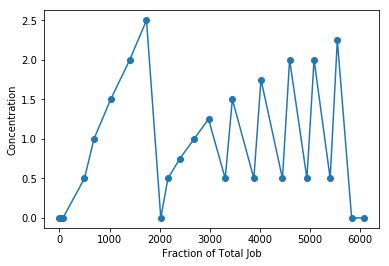

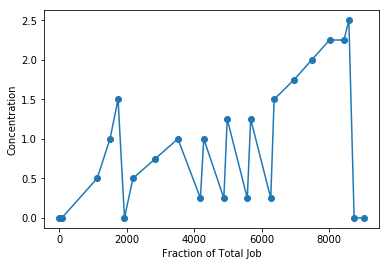

In [48]:
for i,arr in enumerate(well_list):
    w = well_list[i]
    x = pump_final[pump_final['WELL_ID']==w].CUM_FLUID
    y = pump_final[pump_final['WELL_ID']==w].CONC
    plt.plot(x,y,'o-')
    plt.xlabel('Fraction of Total Job')
    plt.ylabel('Concentration')
    plt.show()

In [49]:
# What do the pump curves in each cluster look like?
# Filter pump_final data frame for wells in the same category
# Plot each pump curve as a subplot to visualize them all together

category_df

,0,WELL_ID
0,8,1000
1,1,1001
2,1,1002
3,1,1003
4,1,1004
5,3,1005
6,1,1006
7,3,1007
8,1,1008
9,1,1009


#### Next Steps:
- Use different clustering algorithms and examine results
    - DBSCAN
    - Hierarchical Clustering
    - Gaussian Mixture Model? http://scikit-learn.org/stable/modules/mixture.html
        - Takes into account correlations between features
        - Assumes order matters
        - Ref: https://brilliant.org/wiki/gaussian-mixture-model/
- Incorportate cluster label into company's MVR model